# Identify different types of cell nuclei in a colon cancer sample

In [ ]:
!unzip -q deep-learning-for-msc-coursework-2021.zip

In [ ]:
!ls

deep-learning-for-msc-coursework-2021.zip  sample_data	train
example.csv				   test		train.csv


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

import matplotlib.image as mpimg
import cv2
from imgaug import augmenters as iaa

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.io import read_image

import os
import random
from datetime import datetime

In [ ]:
train_data_csv = pd.read_csv('train.csv')
submit_data_csv = pd.DataFrame(data=list(zip(range(10001, 10401), [None]*400)),columns=['Id', 'Type'])

label_keys = {' Connective': 0, ' Immune': 1, ' Cancer': 2, ' Normal': 3}

train_data_csv.head()

,Id,Type
0,1,Connective
1,2,Connective
2,3,Connective
3,4,Connective
4,5,Connective


In [ ]:
def load_images(datadir, df):
    images = []
    for i in range(len(df)):
        im_path = os.path.join(datadir, str(df.iloc[i][0]) + '.png')
        images.append(read_image(im_path).numpy())
    return np.asarray(images)

In [ ]:
X = load_images('train/train', train_data_csv)
y = np.asarray(train_data_csv['Type'])

X_submit = load_images('test/test', submit_data_csv)

print(X.shape)
print(X_submit.shape)

(2190, 3, 64, 64)
(400, 3, 64, 64)


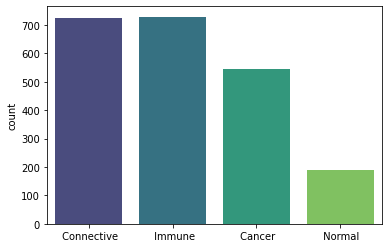

In [ ]:
sns.countplot(x = y, palette = 'viridis')

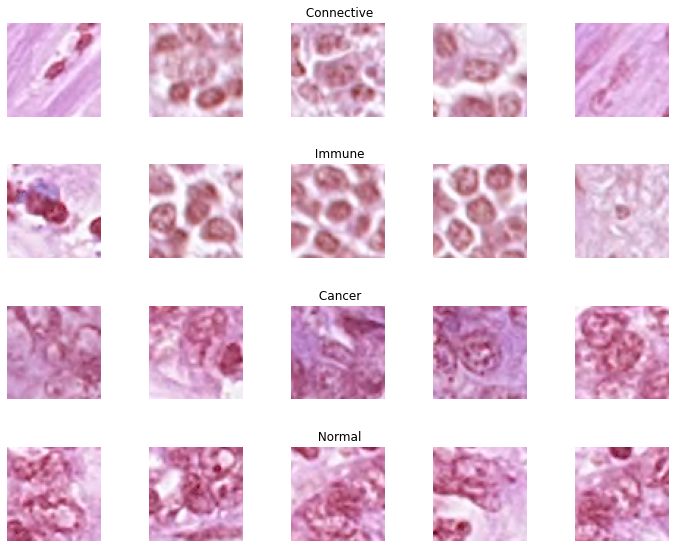

In [ ]:
fig, axs = plt.subplots(nrows = 4, ncols= 5, figsize = (10,8))
fig.tight_layout()
for j,k in enumerate(train_data_csv['Type'].unique()):
    for i in range(5):
        axs[j][i].imshow(torch.from_numpy(X[y==k][np.random.randint(1,len(X[y==k])), :, :]).permute(1, 2, 0))
        axs[j][i].axis('off')
    axs[j][2].set_title(k) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print(X_train.shape)
print(X_test.shape)

(1533, 3, 64, 64)
(657, 3, 64, 64)


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = torch.from_numpy(self.X[idx])
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return (image, label)

In [ ]:
train_dataset = CustomImageDataset(X_train, y_train, transform=lambda x: x/255, target_transform=lambda t: label_keys[t])
test_dataset = CustomImageDataset(X_test, y_test, transform=lambda x: x/255, target_transform=lambda t: label_keys[t])

In [ ]:
batch_size = 128
K = 4
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

#Baseline Model

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(128 * 7 * 7, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, K)   
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # print("inputs.shape:", inputs.shape)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      # print("about to get model output")
      outputs = model(inputs)
      # print("done getting model output")
      # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      # print("about to optimize")
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

In [ ]:
X_submit_tensor = torch.tensor(X_submit) / 255
X_submit_tensor = X_submit_tensor.to(device)

outputs = model(X_submit_tensor)
_, predictions = torch.max(outputs, 1)

submit_data_csv['Type'] = list(map(lambda t: list(label_keys.keys())[list(label_keys.values()).index(t)], predictions))

In [ ]:
submit_data_csv.to_csv('submit_1.csv', index=False) #24

#Better Baseline Model

In [ ]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    
    # define the conv layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )

    # define the linear layers
    self.fc1 = nn.Linear(128 * 8 * 8, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, K)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.3)
    x = F.relu(self.fc2(x))
    x = F.dropout(x, p=0.2)
    x = self.fc3(x)
    return x

In [ ]:
model = CNN(4)

In [ ]:
from torchsummary import summary

In [ ]:
model = CNN(4)
try:
    summary(model.cuda(), (3, 64, 64))
except:
    summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
              ReLU-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
             ReLU-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
        MaxPool2d-14           [-1, 64,

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=80)

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  
  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

In [ ]:
X_submit_tensor = torch.tensor(X_submit) / 255
X_submit_tensor = X_submit_tensor.to(device)

outputs = model(X_submit_tensor)
_, predictions = torch.max(outputs, 1)

submit_data_csv['Type'] = list(map(lambda t: list(label_keys.keys())[list(label_keys.values()).index(t)], predictions))

In [ ]:
submit_data_csv.to_csv('submit_1.csv', index=False) #64

#Data Augmentation

In [ ]:
def calculate_brightness_contrast(image):
    image_cv2_format = np.array(torch.from_numpy(image).permute(1, 2, 0))
    image_bw = cv2.cvtColor(image_cv2_format, cv2.COLOR_BGR2GRAY)
    return (image_bw[10:55, 10:55].mean(), image_bw[10:55, 10:55].std())

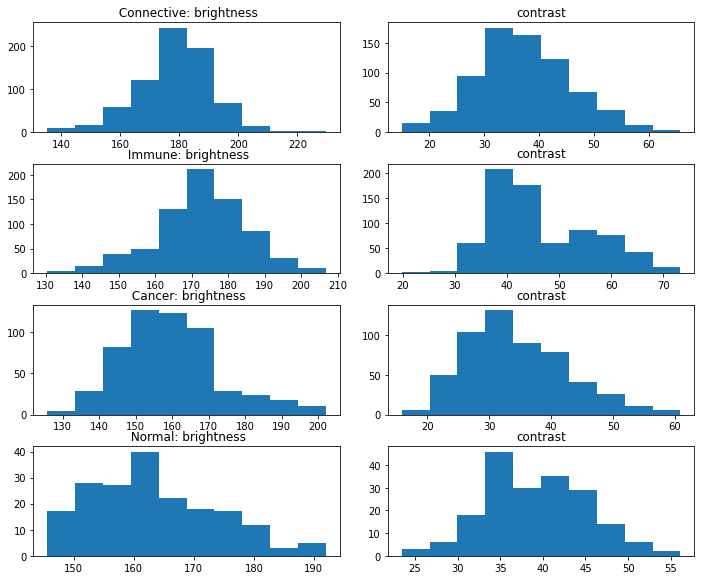

In [ ]:
fig, axs = plt.subplots(nrows = 4, ncols= 2, figsize = (10,8))
fig.tight_layout()
for j,k in enumerate(train_data_csv['Type'].unique()):
    aux_data = list(map(calculate_brightness_contrast, X[y==k]))
    axs[j][0].hist([b for b,c in aux_data])
    axs[j][1].hist([c for b,c in aux_data])
    axs[j][0].set_title(k + ': brightness')
    axs[j][1].set_title('contrast') 

In [ ]:
def zoom(image):    
    zoom = iaa.Affine(scale=(0.8, 1.2))
    image = zoom.augment_image(image)
    return image

def pan(image):
    pan = iaa.Affine(translate_percent= {"x": (-0.10, 0.10), "y": (-0.10, 0.10)})
    image = pan.augment_image(image)
    return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.8, 1.2))
    image = brightness.augment_image(image)
    return image

def img_contrast(image):
    contrast = iaa.ContrastNormalization((0.8, 1.2))
    image = contrast.augment_image(image)
    return image

def random_augment(image, prob=0.5):
    image = np.array(torch.from_numpy(image).permute(1, 2, 0))
    # if np.random.rand() < 0.5:
    #     image = pan(image)
    # if np.random.rand() < 0.5:
    #     image = zoom(image)
    if np.random.rand() < prob:
        image = img_contrast(image)
    if np.random.rand() < prob:
        image = img_random_brightness(image)
    return np.transpose(image,(2,0,1))

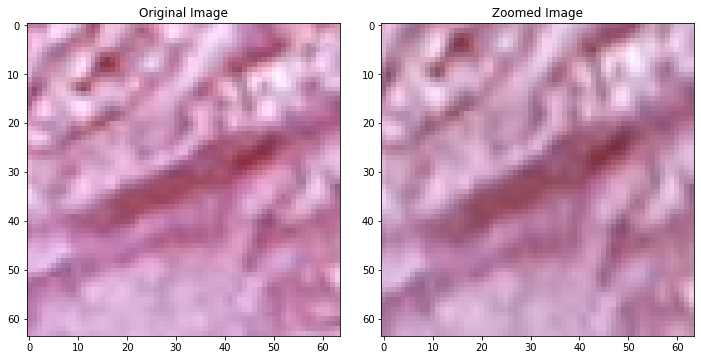

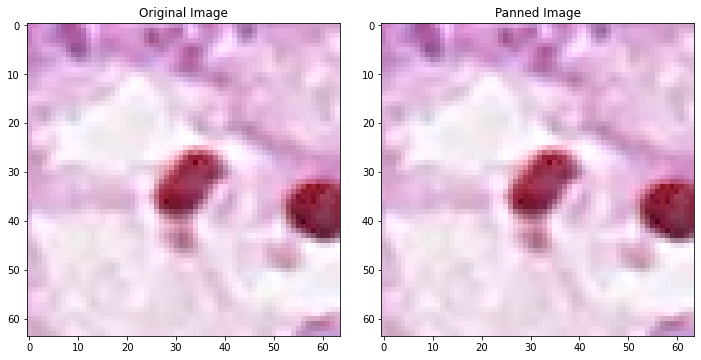

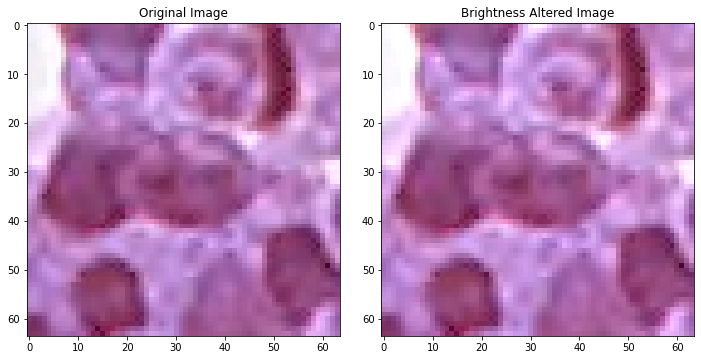

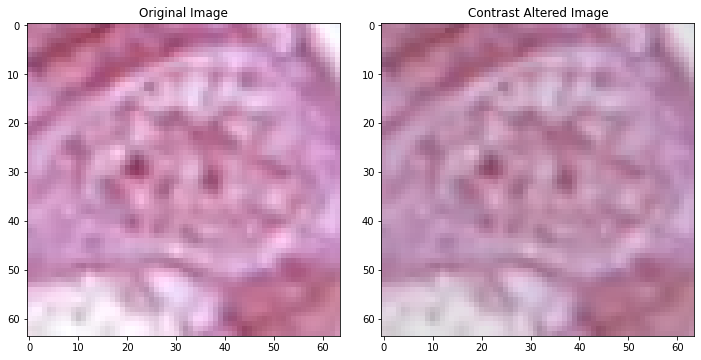

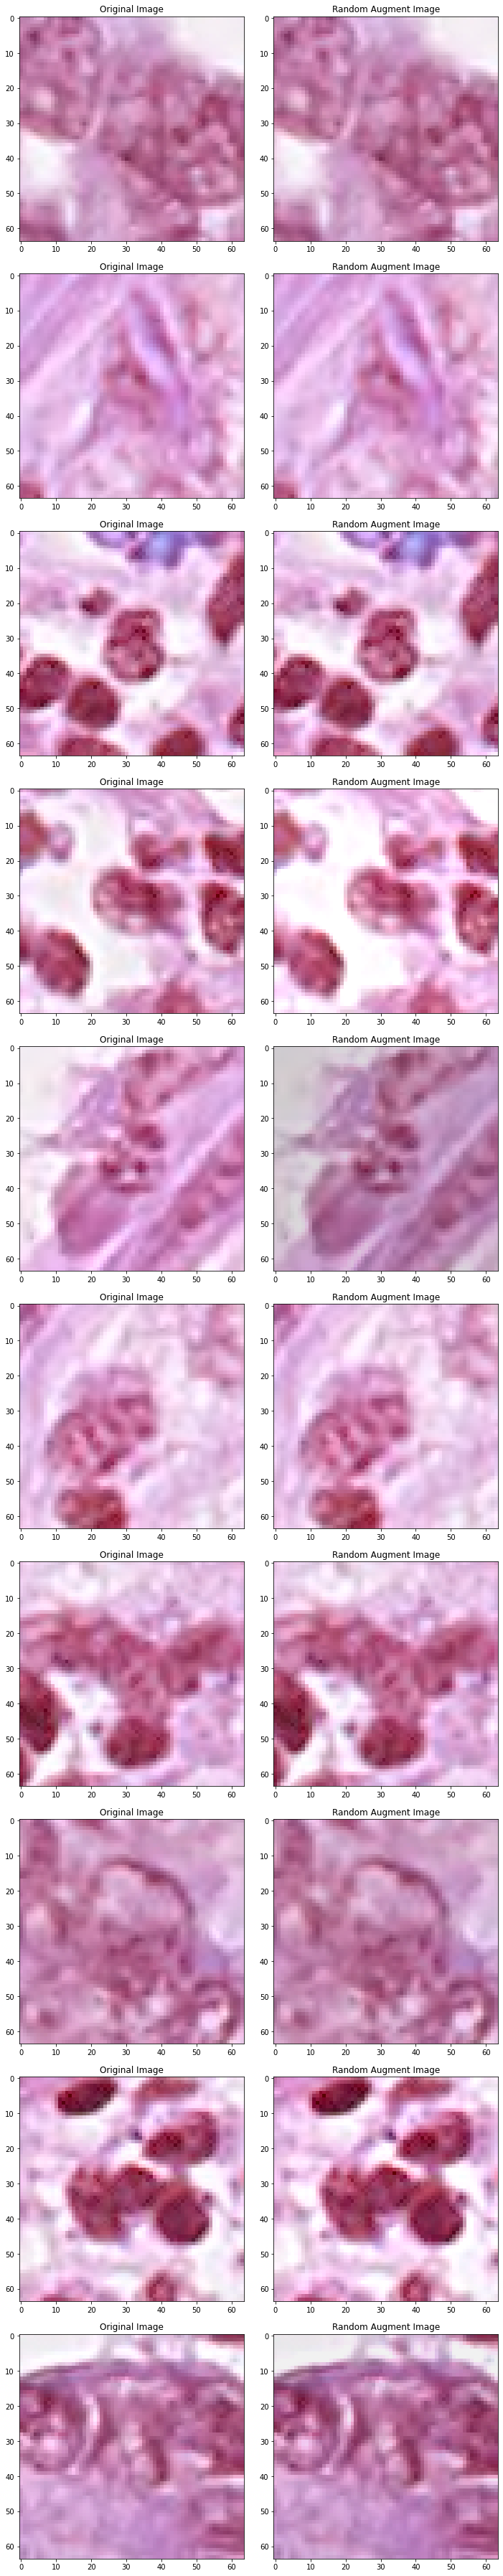

In [ ]:
#Plotting Zoom
original_image = X[random.randint(0, 1000)]
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
 
axs[0].imshow(np.array(torch.from_numpy(original_image).permute(1, 2, 0)))
axs[0].set_title('Original Image')
 
axs[1].imshow(np.array(torch.from_numpy(zoomed_image).permute(1, 2, 0)))
axs[1].set_title('Zoomed Image')

#Plotting Pan
original_image = X[random.randint(0, 1000)]
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
 
axs[0].imshow(np.array(torch.from_numpy(original_image).permute(1, 2, 0)))
axs[0].set_title('Original Image')
 
axs[1].imshow(np.array(torch.from_numpy(panned_image).permute(1, 2, 0)))
axs[1].set_title('Panned Image')

#Plotting Brightness
original_image = X[random.randint(0, 1000)]
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
 
axs[0].imshow(np.array(torch.from_numpy(original_image).permute(1, 2, 0)))
axs[0].set_title('Original Image')
 
axs[1].imshow(np.array(torch.from_numpy(brightness_altered_image).permute(1, 2, 0)))
axs[1].set_title('Brightness Altered Image')


#Plotting Contrast
original_image = X[random.randint(0, 1000)]
contrast_altered_image = img_contrast(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
 
axs[0].imshow(np.array(torch.from_numpy(original_image).permute(1, 2, 0)))
axs[0].set_title('Original Image')
 
axs[1].imshow(np.array(torch.from_numpy(contrast_altered_image).permute(1, 2, 0)))
axs[1].set_title('Contrast Altered Image')


#PLotting Random Augmentation
fig, axs = plt.subplots(10, 2, figsize=(10, 50))
fig.tight_layout()

for i in range(10):
    original_image = X[random.randint(0, 1000)]
    augmented_image = random_augment(original_image)
    
    axs[i][0].imshow(np.array(torch.from_numpy(original_image).permute(1, 2, 0)))
    axs[i][0].set_title('Original Image')
 
    axs[i][1].imshow(np.array(torch.from_numpy(augmented_image).permute(1, 2, 0)))
    axs[i][1].set_title('Random Augment Image')

In [ ]:
def custom_data_generator(X, y, batch_size, steps):
    s = 0
    while s < steps:
        batch_images = []
        batch_labels = []

        for k in train_data_csv['Type'].unique():
            selected_images = X[y==k][list(np.random.randint(0,len(X[y==k]), batch_size//train_data_csv['Type'].nunique()))]
            batch_images.extend(selected_images)
            batch_labels.extend([k]*(batch_size//train_data_csv['Type'].nunique()))
        
        batch_images = np.asarray(list(map(random_augment, batch_images)))
        batch_labels = list(map(lambda t: label_keys[t], batch_labels))

        s += 1
        
        yield (torch.from_numpy(batch_images)/255, torch.tensor(batch_labels))  

In [ ]:
# A function to encapsulate the training loop
def batch_gd_with_datagen(model, criterion, optimizer, train_loader, test_loader, epochs, batch_size, steps):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader(X_train, y_train, batch_size, steps):
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
model = CNN(K)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_losses, test_losses = batch_gd_with_datagen(model, criterion, optimizer, custom_data_generator, test_loader, 100, batch_size, 100)

Epoch 1/100, Train Loss: 0.6592,       Test Loss: 0.7592, Duration: 0:00:16.973539
Epoch 2/100, Train Loss: 0.1915,       Test Loss: 1.2560, Duration: 0:00:16.842084
Epoch 3/100, Train Loss: 0.0835,       Test Loss: 1.4792, Duration: 0:00:16.700178
Epoch 4/100, Train Loss: 0.0529,       Test Loss: 2.5760, Duration: 0:00:16.873313
Epoch 5/100, Train Loss: 0.0441,       Test Loss: 1.6860, Duration: 0:00:16.521342
Epoch 6/100, Train Loss: 0.0253,       Test Loss: 2.6627, Duration: 0:00:16.653229
Epoch 7/100, Train Loss: 0.0185,       Test Loss: 1.6636, Duration: 0:00:16.643955
Epoch 8/100, Train Loss: 0.0345,       Test Loss: 1.7833, Duration: 0:00:16.619543
Epoch 9/100, Train Loss: 0.0251,       Test Loss: 1.6281, Duration: 0:00:16.647135
Epoch 10/100, Train Loss: 0.0182,       Test Loss: 1.8711, Duration: 0:00:16.594658
Epoch 11/100, Train Loss: 0.0201,       Test Loss: 2.8819, Duration: 0:00:16.612103
Epoch 12/100, Train Loss: 0.0246,       Test Loss: 2.2340, Duration: 0:00:16.548539
E

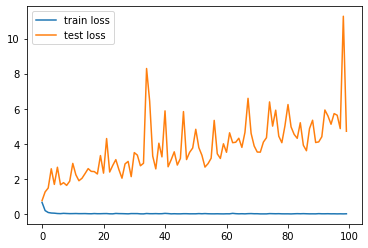

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9948, Test acc: 0.7352


In [ ]:
X_submit_tensor = torch.tensor(X_submit) / 255
X_submit_tensor = X_submit_tensor.to(device)

outputs = model(X_submit_tensor)
_, predictions = torch.max(outputs, 1)

submit_data_csv['Type'] = list(map(lambda t: list(label_keys.keys())[list(label_keys.values()).index(t)], predictions))

In [ ]:
submit_data_csv.to_csv('submit_1.csv', index=False) #

#Better Custom data gen

In [ ]:
def custom_data_generator(X, y, batch_size, steps):
    s = 0
    while s < steps:
        batch_images = []
        batch_labels = []

        for k in train_data_csv['Type'].unique():
            prob = max(0, 1 - len(X[y==k])/(len(X)/train_data_csv['Type'].nunique()))
            selected_images = X[y==k][list(np.random.randint(0,len(X[y==k]), batch_size//train_data_csv['Type'].nunique()))]
            selected_images = np.asarray(list(map(random_augment, selected_images, [prob]*len(selected_images))))
            batch_images.extend(selected_images)
            batch_labels.extend([k]*(batch_size//train_data_csv['Type'].nunique()))
        
        batch_images = np.asarray(batch_images)
        batch_labels = list(map(lambda t: label_keys[t], batch_labels))

        s += 1
        yield (torch.from_numpy(batch_images)/255, torch.tensor(batch_labels))  

In [ ]:
# A function to encapsulate the training loop
def batch_gd_with_datagen(model, criterion, optimizer, train_loader, test_loader, epochs, batch_size, steps):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader(X_train, y_train, batch_size, steps):
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
model = CNN(K)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_losses, test_losses = batch_gd_with_datagen(model, criterion, optimizer, custom_data_generator, test_loader, 100, batch_size, 100)

Epoch 1/100, Train Loss: 0.5555,       Test Loss: 0.6763, Duration: 0:00:21.912347
Epoch 2/100, Train Loss: 0.1563,       Test Loss: 0.8912, Duration: 0:00:21.948420
Epoch 3/100, Train Loss: 0.0606,       Test Loss: 1.2878, Duration: 0:00:21.798729
Epoch 4/100, Train Loss: 0.0526,       Test Loss: 1.2376, Duration: 0:00:21.644494
Epoch 5/100, Train Loss: 0.0296,       Test Loss: 1.6965, Duration: 0:00:21.763595
Epoch 6/100, Train Loss: 0.0385,       Test Loss: 1.5357, Duration: 0:00:21.772713
Epoch 7/100, Train Loss: 0.0270,       Test Loss: 1.6271, Duration: 0:00:21.821204
Epoch 8/100, Train Loss: 0.0239,       Test Loss: 1.6474, Duration: 0:00:21.761380
Epoch 9/100, Train Loss: 0.0135,       Test Loss: 1.8409, Duration: 0:00:21.969175
Epoch 10/100, Train Loss: 0.0123,       Test Loss: 2.2880, Duration: 0:00:21.755752
Epoch 11/100, Train Loss: 0.0245,       Test Loss: 1.3250, Duration: 0:00:21.745591
Epoch 12/100, Train Loss: 0.0172,       Test Loss: 1.8090, Duration: 0:00:21.795062
E

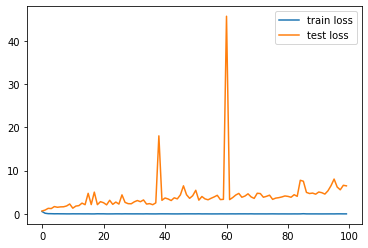

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9843, Test acc: 0.7397


In [ ]:
X_submit_tensor = torch.tensor(X_submit) / 255
X_submit_tensor = X_submit_tensor.to(device)

outputs = model(X_submit_tensor)
_, predictions = torch.max(outputs, 1)

submit_data_csv['Type'] = list(map(lambda t: list(label_keys.keys())[list(label_keys.values()).index(t)], predictions))

In [ ]:
submit_data_csv.to_csv('submit_1.csv', index=False) #